# Model Evaluation Notebook

This notebook evaluates the performance of the trained transformer model against baseline methods.

## Setup and Data Loading

In [1]:
import sys
sys.path.append("..")

from core.DataLoader import DataPreprocessor, get_load_config_from_yaml
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.assignment_models as Models
import core
import os

# Configuration
PLOTS_DIR = "plots/assignment_transformer_HLF/"
MODEL_DIR = "../models/FeatureConcatTransformer_HLF_d256_l6_h8"
CONFIG_PATH = "../config/workspace_config_HLF.yaml"

# Create directories
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Set plotting style
plt.rcParams.update({"font.size": 14})

# Load data
load_config = get_load_config_from_yaml(CONFIG_PATH)
DataProcessor = DataPreprocessor(load_config)

with open(CONFIG_PATH, "r") as file:
    data_configs = yaml.safe_load(file)

data_config = DataProcessor.load_from_npz(
    data_configs["data_path"]["nominal"], 
    max_events=10000000
)
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.5)
del DataProcessor

print(f"Loaded {len(X_train['jet'])} training events and {len(X_val['jet'])} validation events")

2025-11-25 15:17:45.746514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764080265.771617 2539974 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764080265.779850 2539974 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764080265.799820 2539974 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764080265.799842 2539974 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764080265.799845 2539974 computation_placer.cc:177] computation placer alr

Loaded 4993629 training events and 4993630 validation events


## Load Model and Setup Evaluator

In [2]:
reload(Models)
reload(core)
TransformerMatcher = Models.FeatureConcatTransformer(data_config, name=r"Transformer + $\nu^2$-Flows")

FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.


In [3]:
TransformerMatcher.load_model(f"{MODEL_DIR}/model.keras")

I0000 00:00:1764080447.875824 2539974 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model loaded from ../models/FeatureConcatTransformer_HLF_d256_l6_h8/model.keras


In [4]:
import core.reconstruction.BaselineMethods as BaselineMethods
import core.evaluation as Evaluation
from core.reconstruction import GroundTruthReconstructor

reload(Evaluation)
reload(BaselineMethods)
delta_r_assigner = BaselineMethods.DeltaRAssigner(
    data_config,
    use_nu_flows=True,
)
chi_square = BaselineMethods.ChiSquareAssigner(
    data_config,
    use_nu_flows=True,
    use_nu_flows_for_assignment=True,
    top_mass=173.5e3,
)


ground_truth_assigner = GroundTruthReconstructor(
    data_config, name=r"True Assignment + $\nu^2$-Flows", use_nu_flows=True
)
evaluator = Evaluation.ReconstructionEvaluator(
    [
        delta_r_assigner,
        #chi_square_true_nu,
        chi_square,
        TransformerMatcher,
        ground_truth_assigner,
    ],
    X_val,
    y_val,
)

/afs/desy.de/user/a/aulich/mva-trainer/notebooks/../core/reconstruction/BaselineMethods.py:346: RuntimeWarning: invalid value encountered in subtract
  mass_squared = e**2 - (px**2 + py**2 + pz**2)


I0000 00:00:1764080551.455251 2543190 service.cc:152] XLA service 0x7f02e4004230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764080551.455632 2543190 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-11-25 15:22:31.527653: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-25 15:22:31.574513: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764080551.958939 2543190 cuda_dnn.cc:529] Loaded cuDNN version 91500
I0000 00:00:1764080553.558443 2543190 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-25 15:25:18.934119: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring

## Distribution Plots

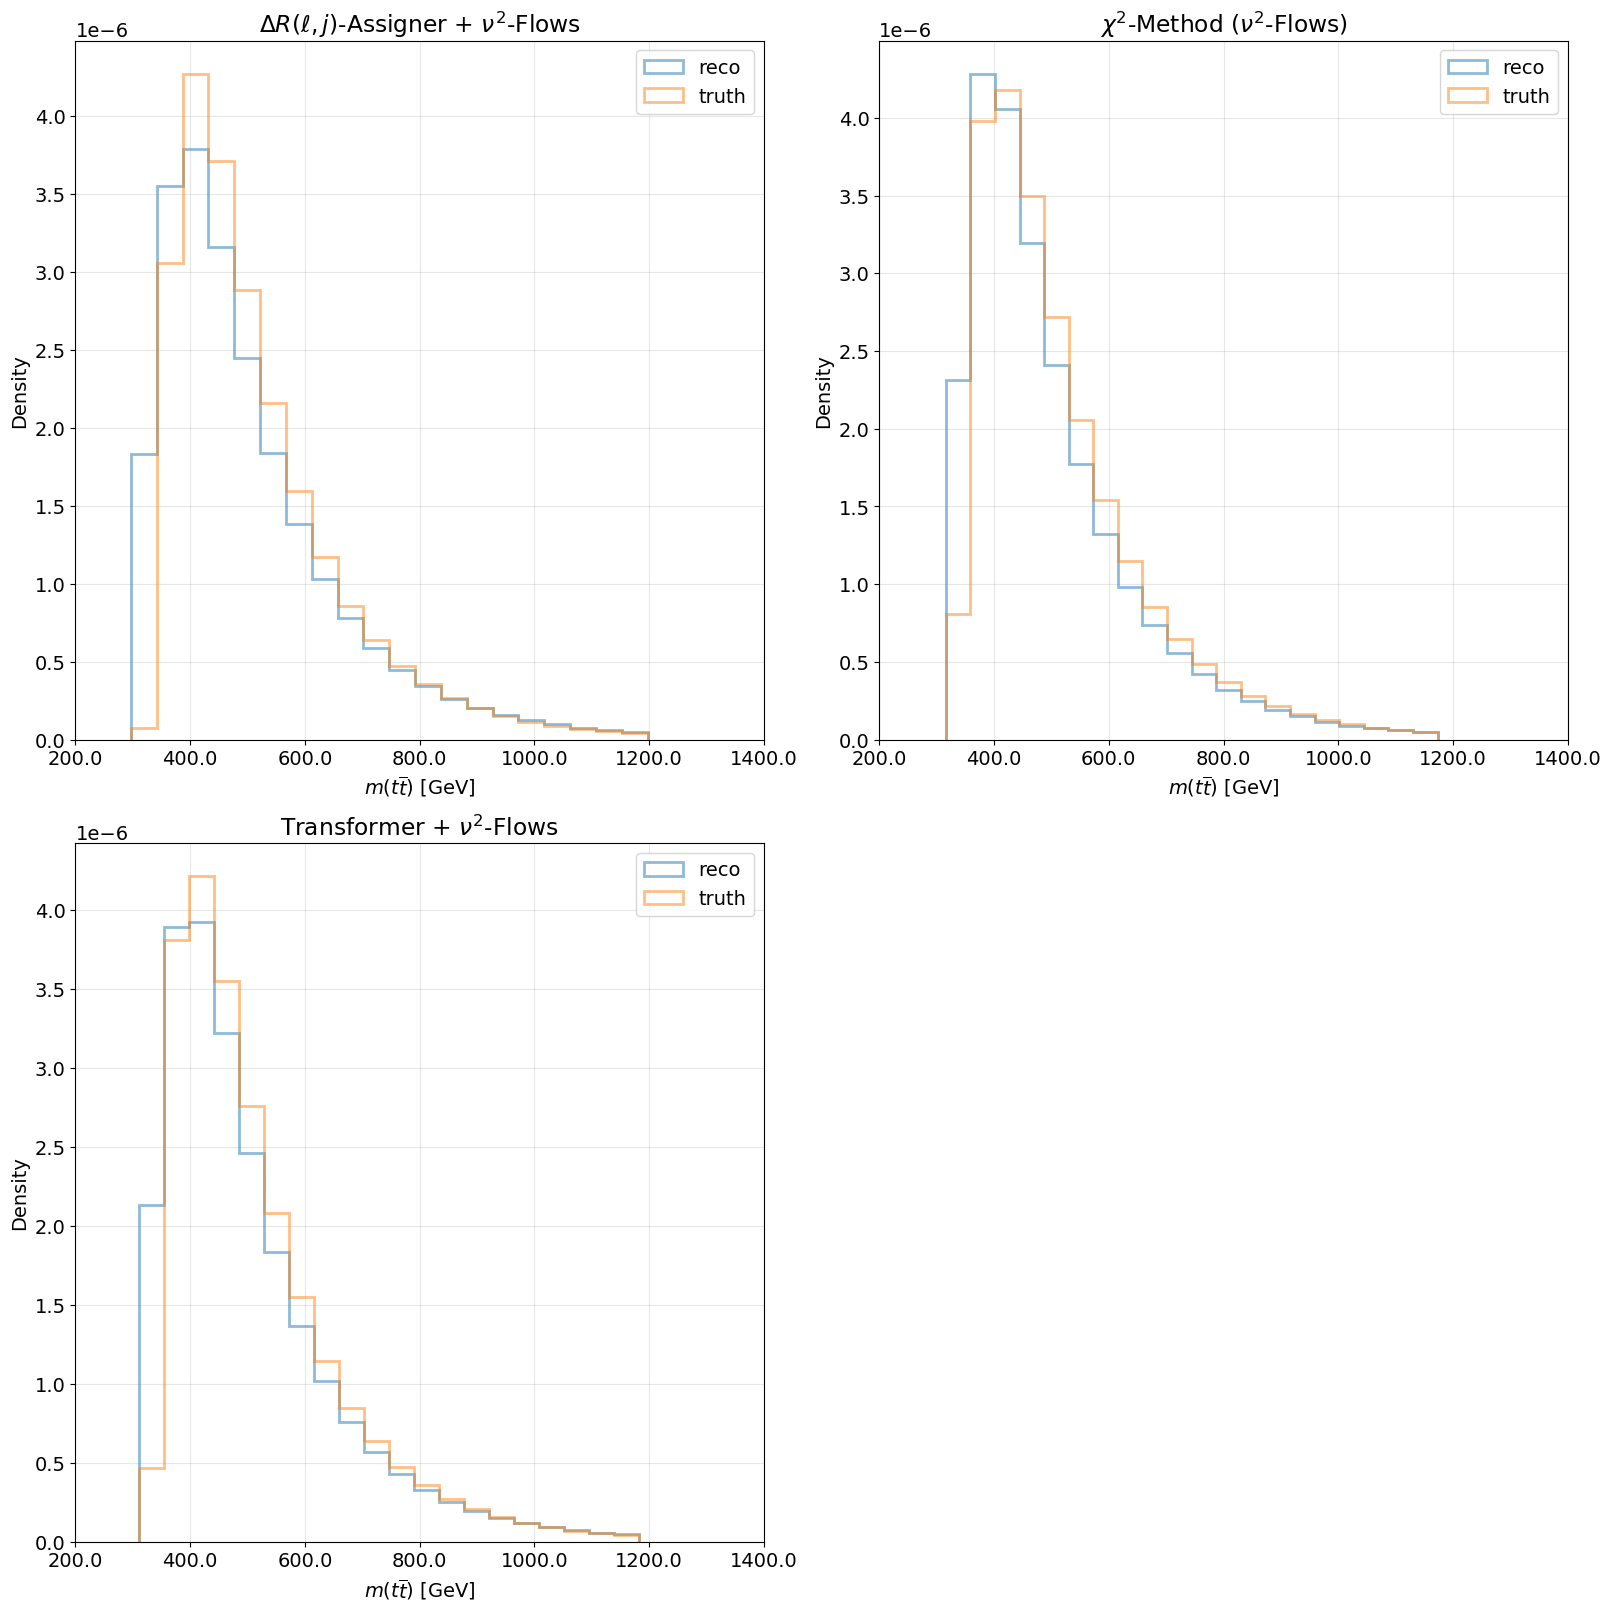

In [5]:
fig, ax = evaluator.plot_ttbar_mass_distributions(bins = 20, figsize=(16,16))
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_distributions.png", bbox_inches="tight")

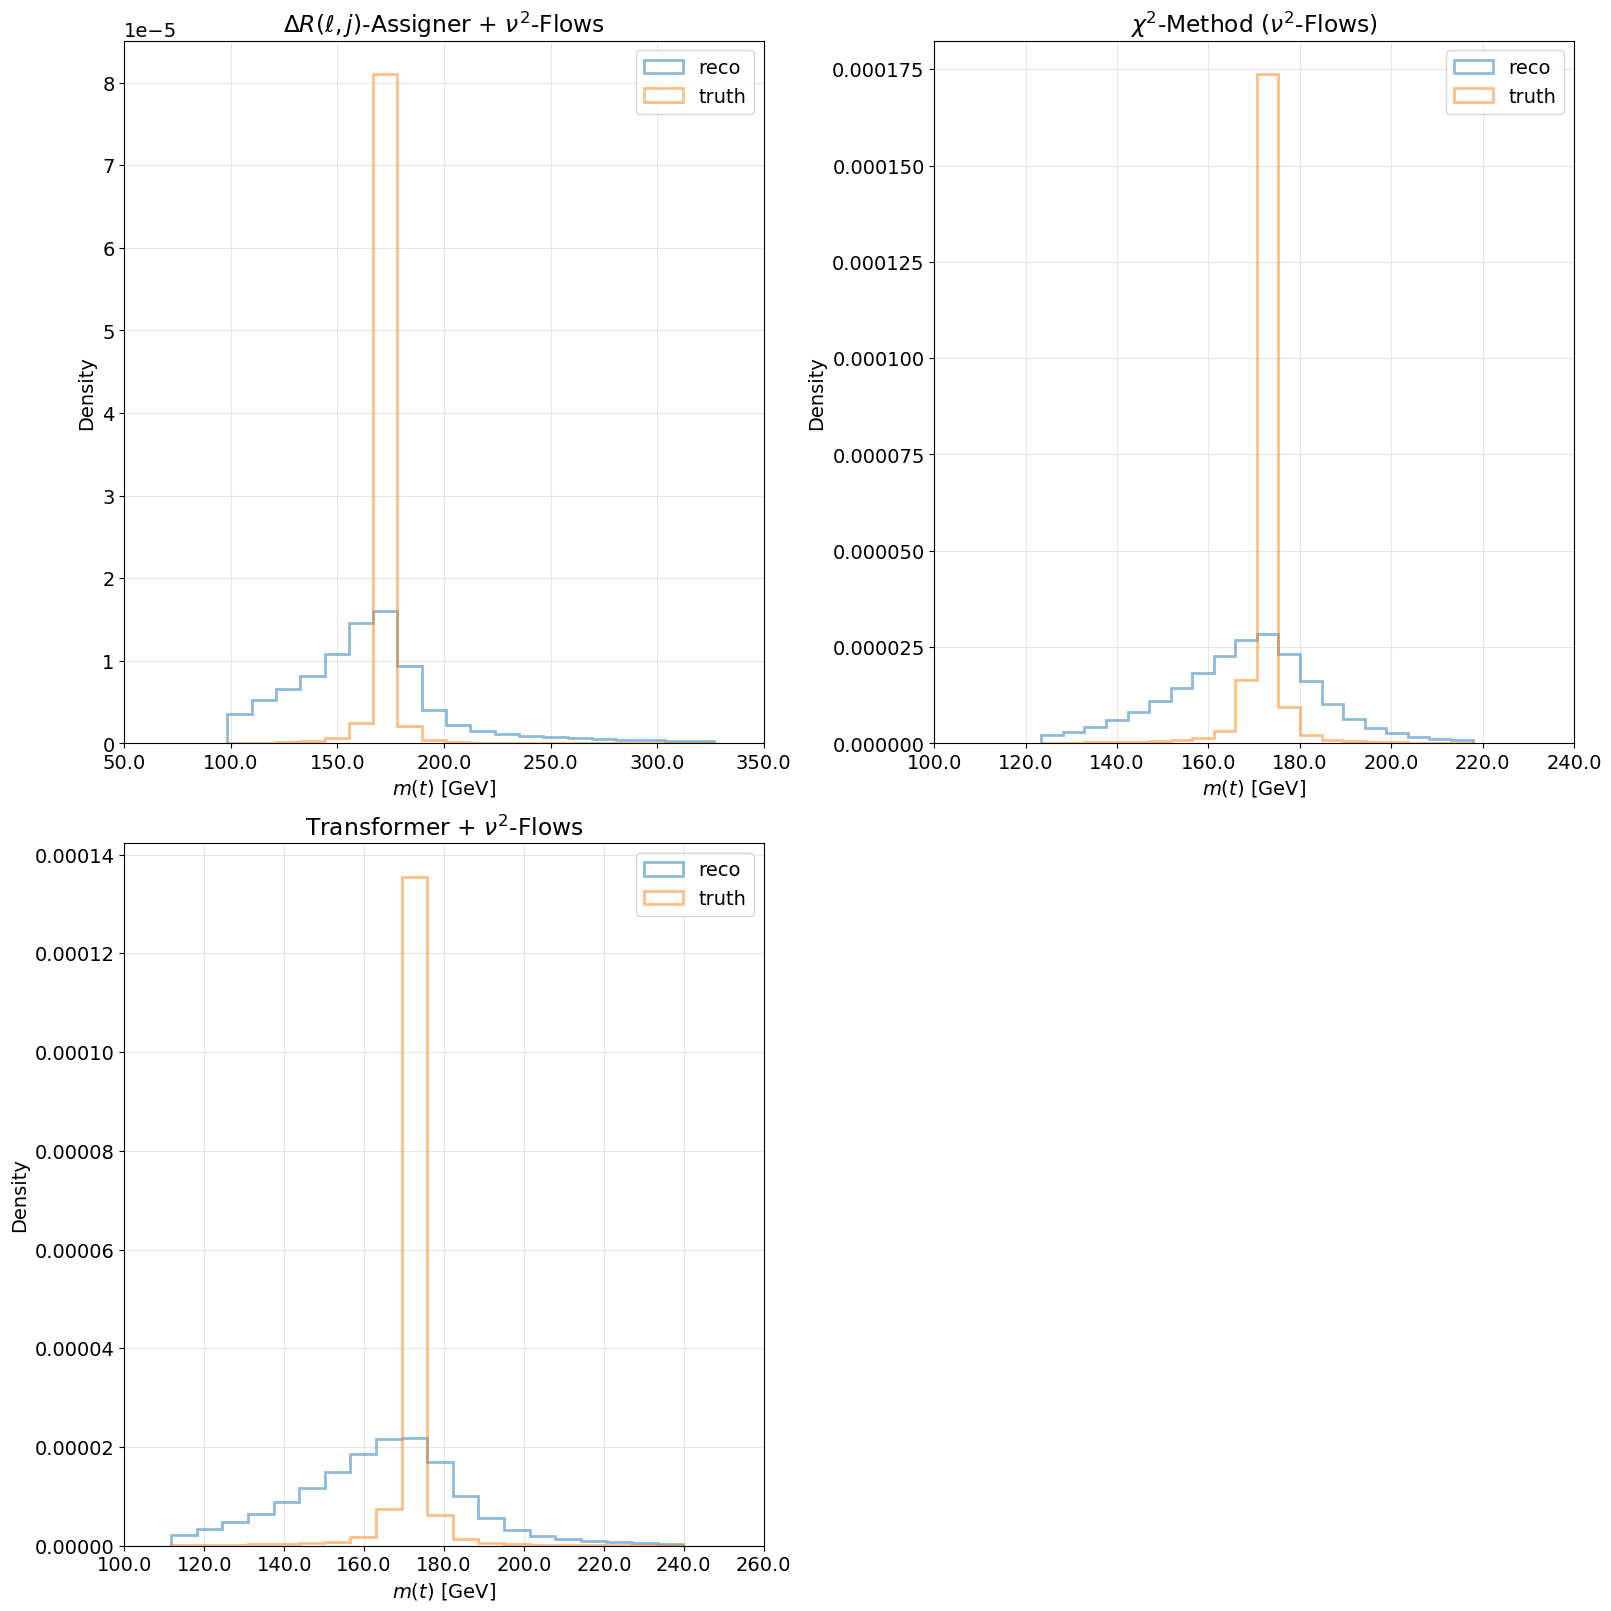

In [6]:
fig, ax = evaluator.plot_top_mass_distributions(bins = 20, figsize=(16,16))
fig.savefig(f"{PLOTS_DIR}/top_mass_distributions.png", bbox_inches="tight")

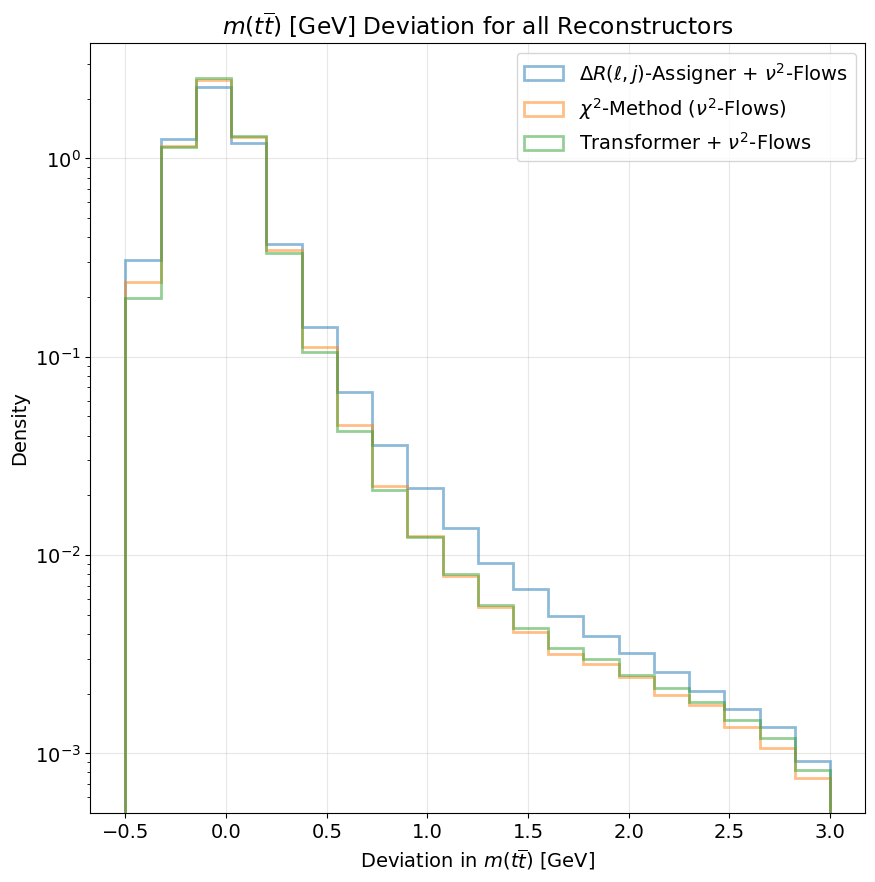

In [7]:
fig, ax = evaluator.plot_ttbar_mass_deviation_distribution(bins = 20, xlims = (-0.5, 3))
ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_deviation_distribution.png", bbox_inches="tight")

/afs/desy.de/user/a/aulich/mva-trainer/notebooks/../core/evaluation/physics_calculations.py:226: RuntimeWarning: invalid value encountered in multiply
  v_par_coeff = np.sum(vv * n, axis=1)[:, None]   # scalar (N,1)
/afs/desy.de/user/a/aulich/mva-trainer/notebooks/../core/evaluation/physics_calculations.py:231: RuntimeWarning: invalid value encountered in multiply
  v_par_prime = gamma[:, None] * (v_par + beta * E[:, None] * n)


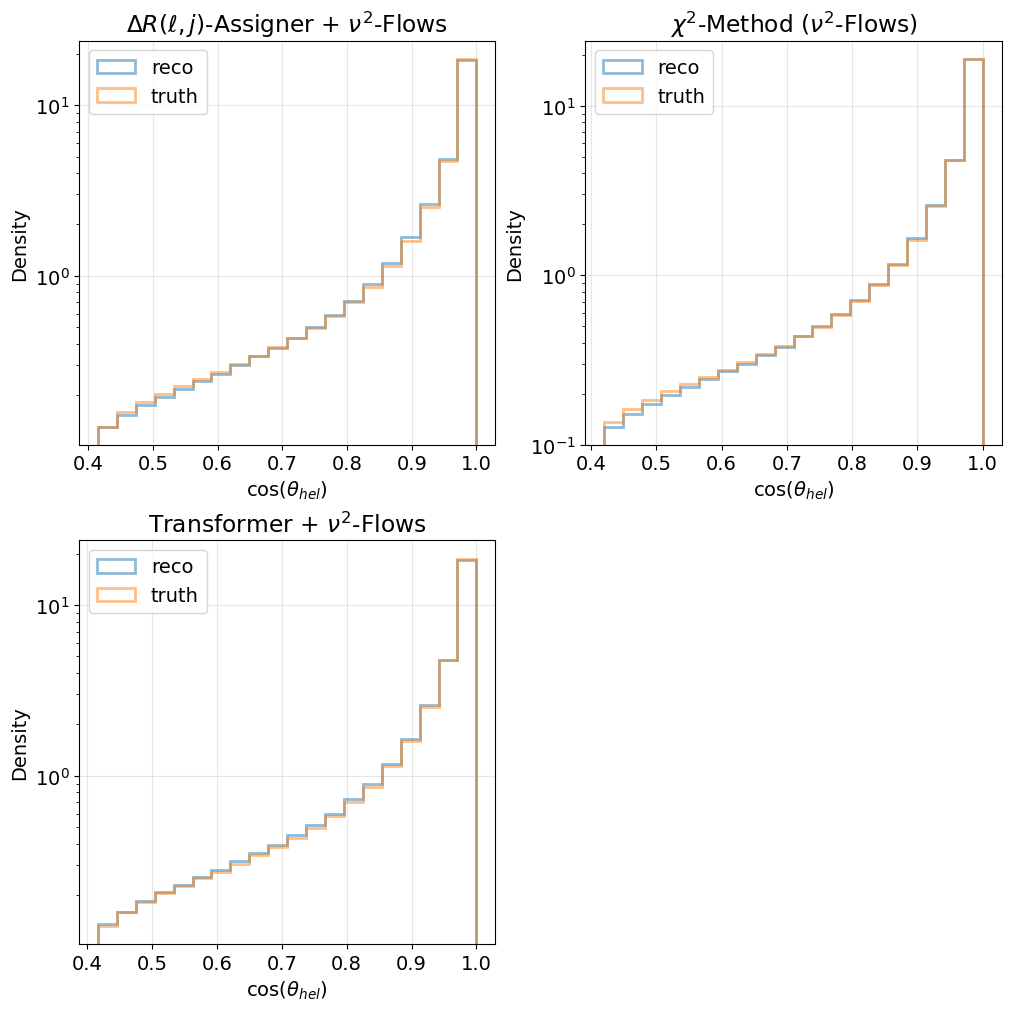

In [8]:
fig, axes = evaluator.plot_c_hel_distributions(bins = 20)
for ax in axes:
    ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/c_hel_distributions.png", bbox_inches="tight")

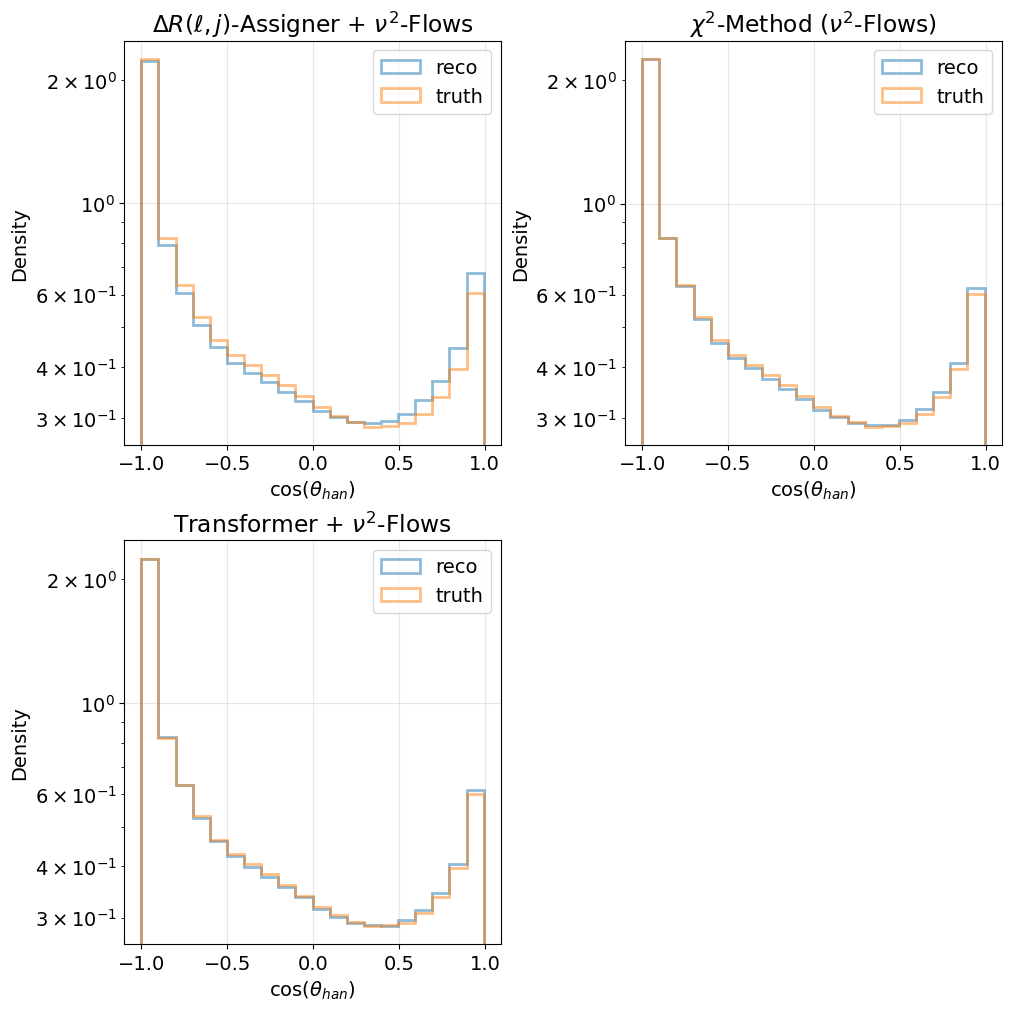

In [9]:
fig, axes = evaluator.plot_c_han_distributions(bins = 20)
for ax in axes:
    ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/c_han_distributions.png", bbox_inches="tight")

## Resolution Plots


Computing binned $\cos(\theta_{hel})$ Resolution for truth_ttbar_mass...


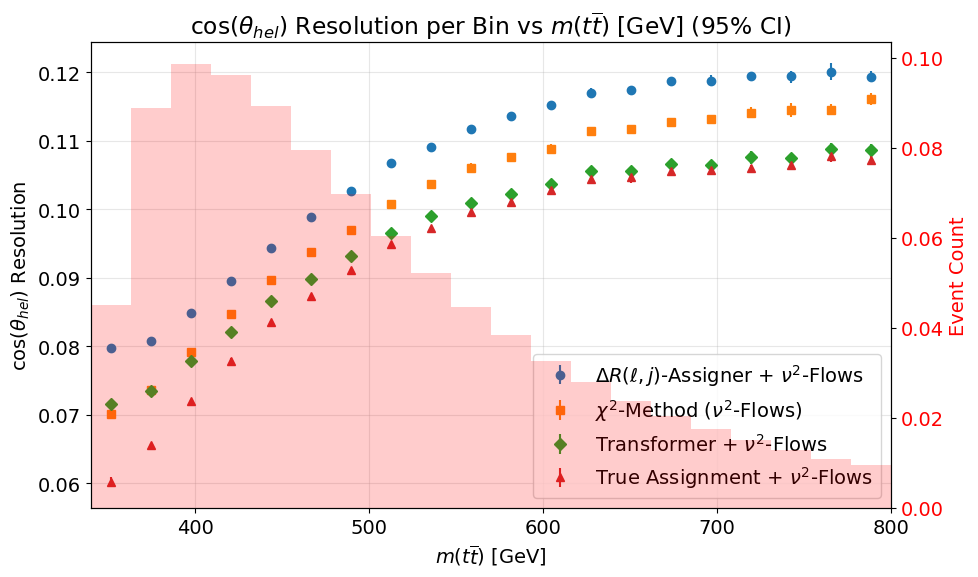

In [10]:
fig, ax = evaluator.plot_binned_c_hel_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_hel_resolution_comparison.pdf")


Computing binned $\cos(\theta_{han})$ Resolution for truth_ttbar_mass...


/afs/desy.de/user/a/aulich/mva-trainer/notebooks/../core/evaluation/physics_calculations.py:226: RuntimeWarning: invalid value encountered in multiply
  v_par_coeff = np.sum(vv * n, axis=1)[:, None]   # scalar (N,1)
/afs/desy.de/user/a/aulich/mva-trainer/notebooks/../core/evaluation/physics_calculations.py:231: RuntimeWarning: invalid value encountered in multiply
  v_par_prime = gamma[:, None] * (v_par + beta * E[:, None] * n)


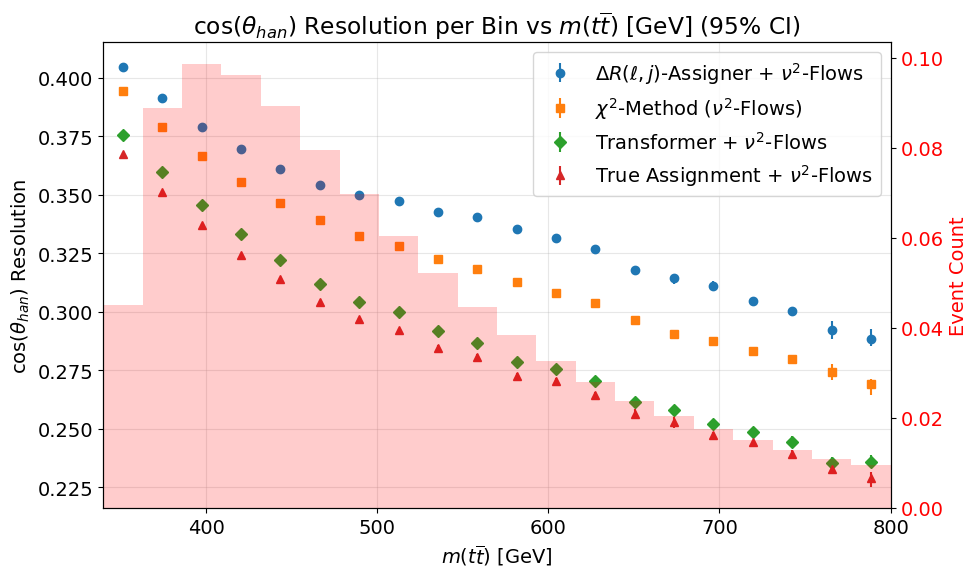

In [11]:
fig, ax = evaluator.plot_binned_c_han_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_han_resolution_comparison.pdf")


Computing binned Relative $m(t\overline{t})$ Resolution for truth_ttbar_mass...


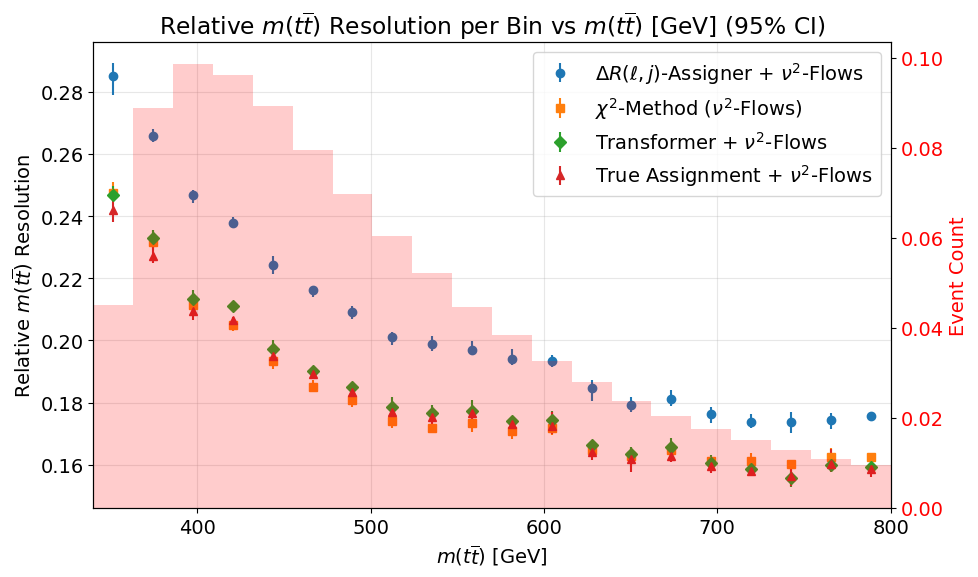

In [12]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")


Computing bootstrap confidence intervals...
$\Delta R(\ell,j)$-Assigner + $\nu^2$-Flows: 0.4761 [0.4757, 0.4765]
$\chi^2$-Method ($\nu^2$-Flows): 0.6094 [0.6091, 0.6097]
Transformer + $\nu^2$-Flows: 0.8147 [0.8145, 0.8149]
True Assignment + $\nu^2$-Flows: Ground Truth (skipping)


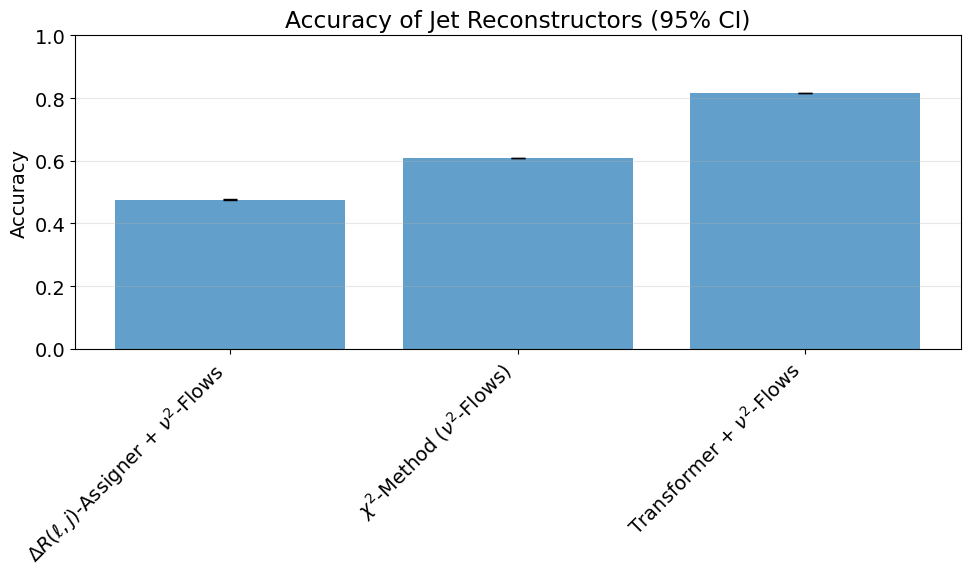

In [13]:
fig, ax = evaluator.plot_all_accuracies(
    n_bootstrap=10
)
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")

## Accuracy Plots


Computing binned accuracy for N_jets...


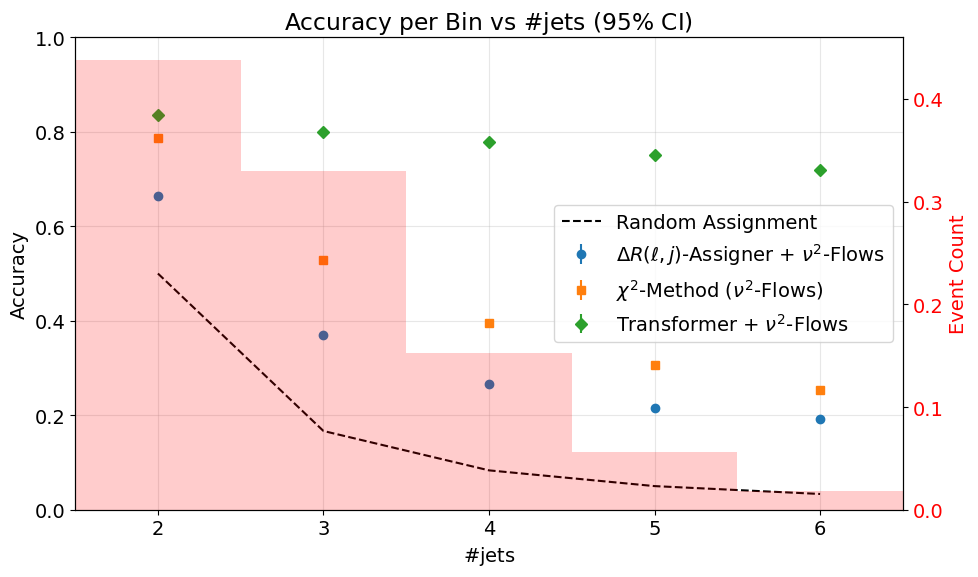

In [14]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_configs["LoadConfig"]["max_jets"] + 1),
    bins=data_configs["LoadConfig"]["max_jets"] - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
ax.set_xticklabels([i for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")


Computing binned accuracy for truth_ttbar_mass...


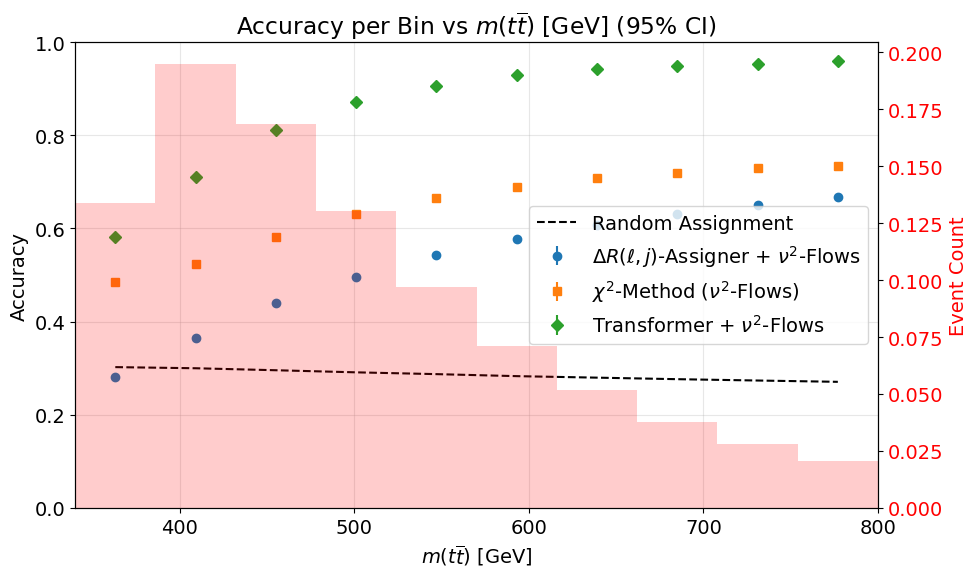

In [15]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_pt...


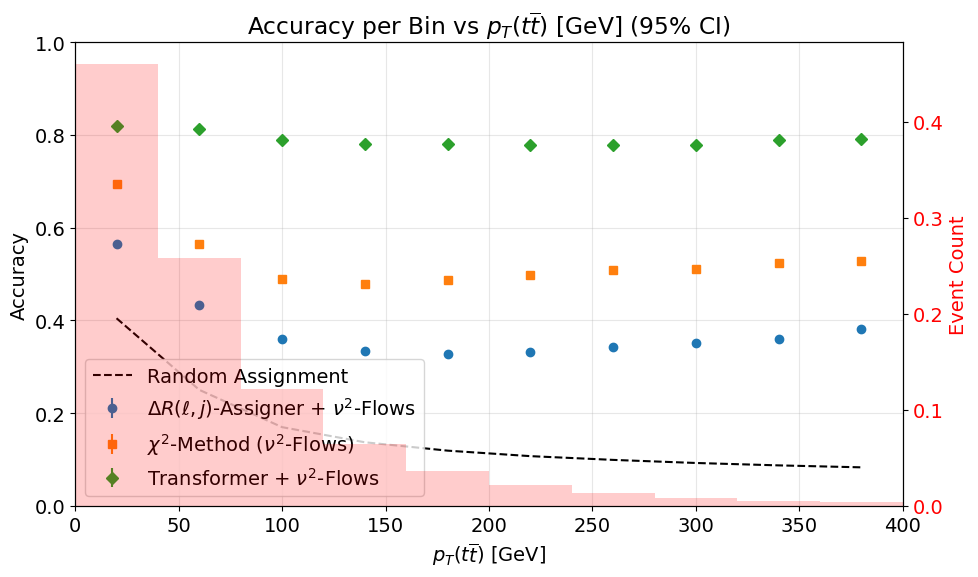

In [16]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)

fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")


Computing binned Relative $m(t)$ Resolution for truth_ttbar_mass...


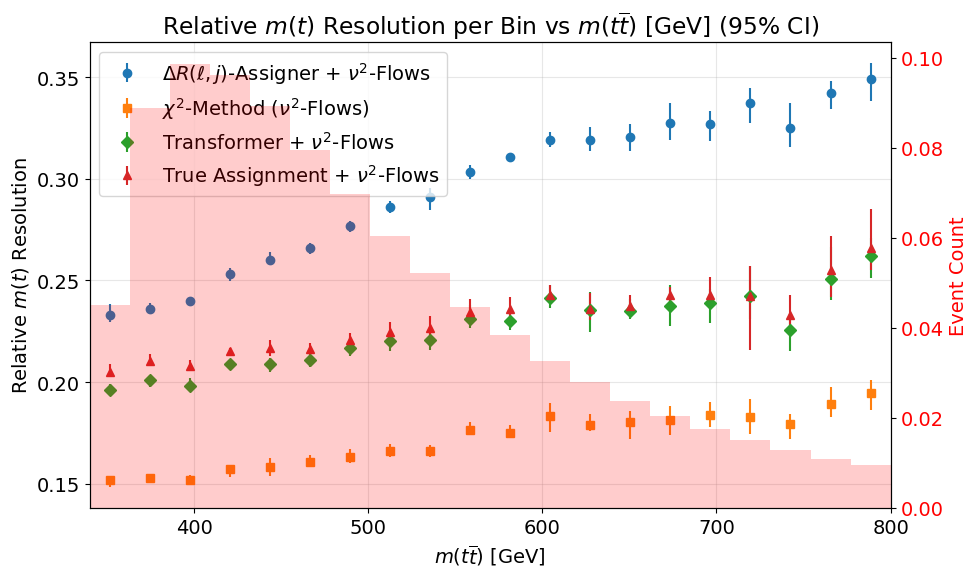

In [17]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")

## Mass Resolution and Deviation Plots


Computing binned Mean Relative $m(t)$ Deviation for truth_ttbar_mass...


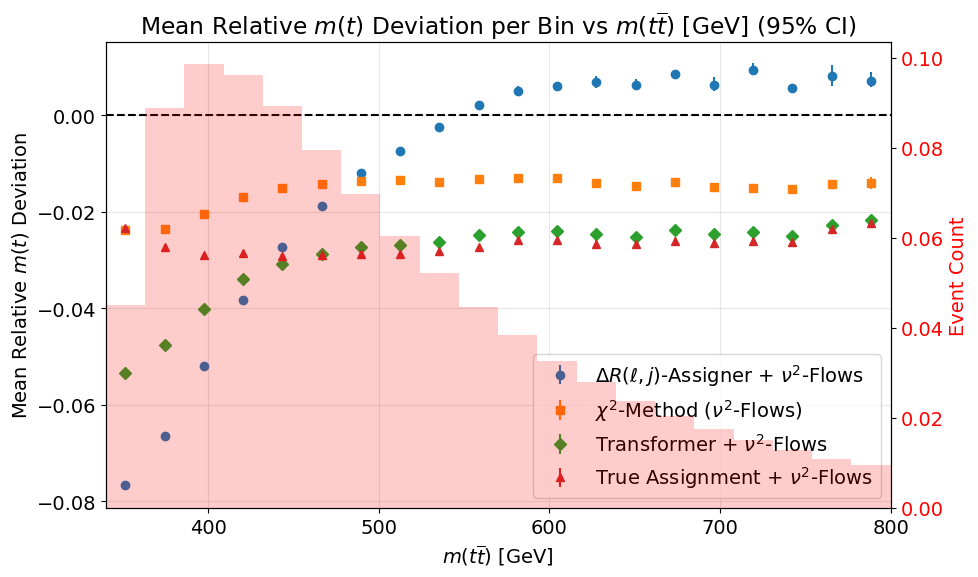

In [18]:
fig, ax = evaluator.plot_binned_top_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.axhline(0, color="black", linestyle="--")
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_deviation_comparison.pdf")


Computing binned Mean Relative $m(t\overline{t})$ Deviation for truth_ttbar_mass...


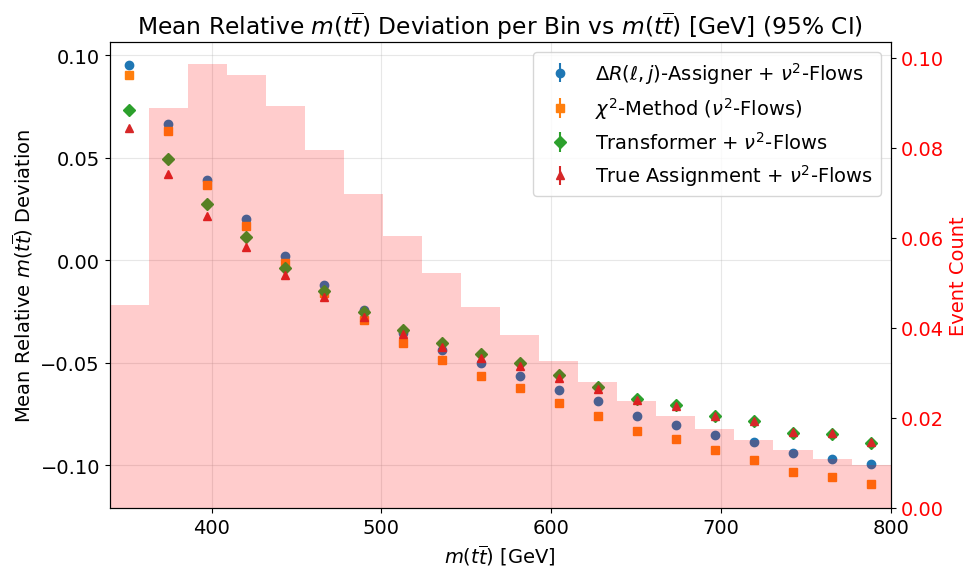

In [19]:
fig, ax = evaluator.plot_binned_ttbar_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_deviation_comparison.pdf")


Computing binned accuracy for truth_ttbar_mass...


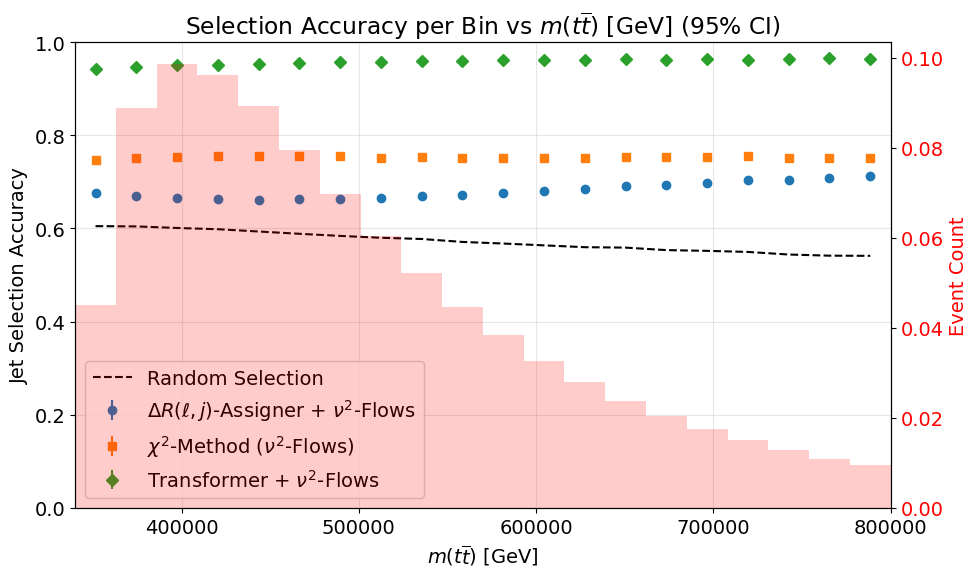

In [20]:
evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_ttbar_mass.pdf")

## Confusion Matrices and Complementarity


Computing binned accuracy for truth_initial_parton_num_gluons...


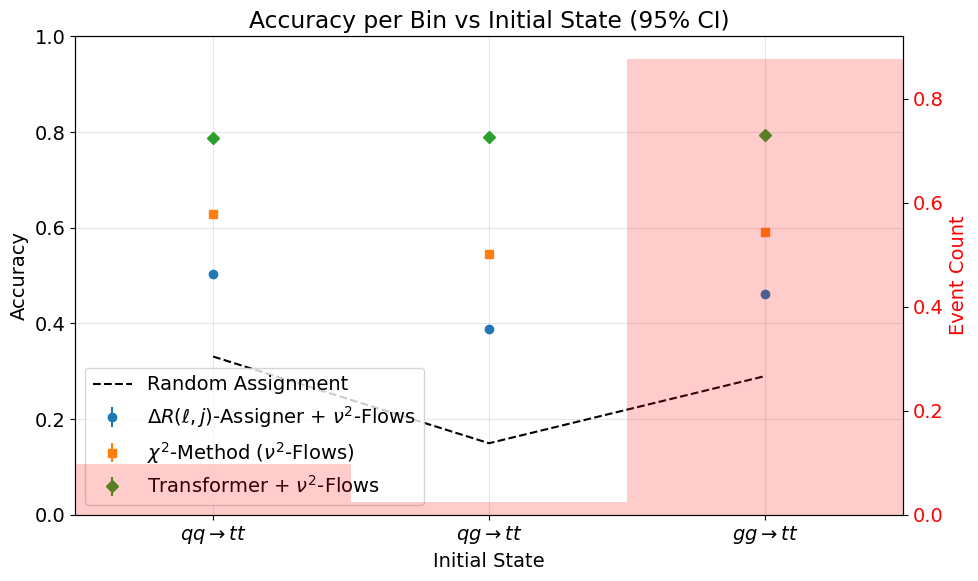

In [21]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")

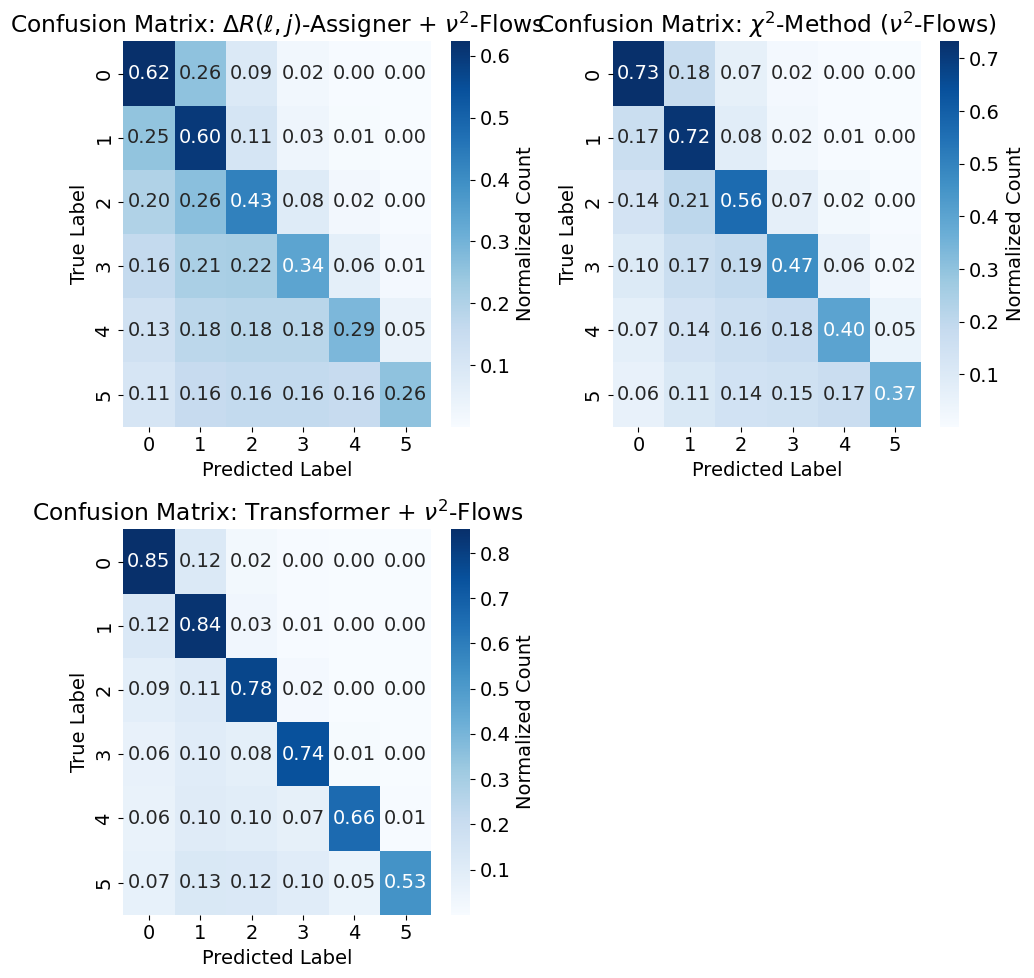

In [22]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

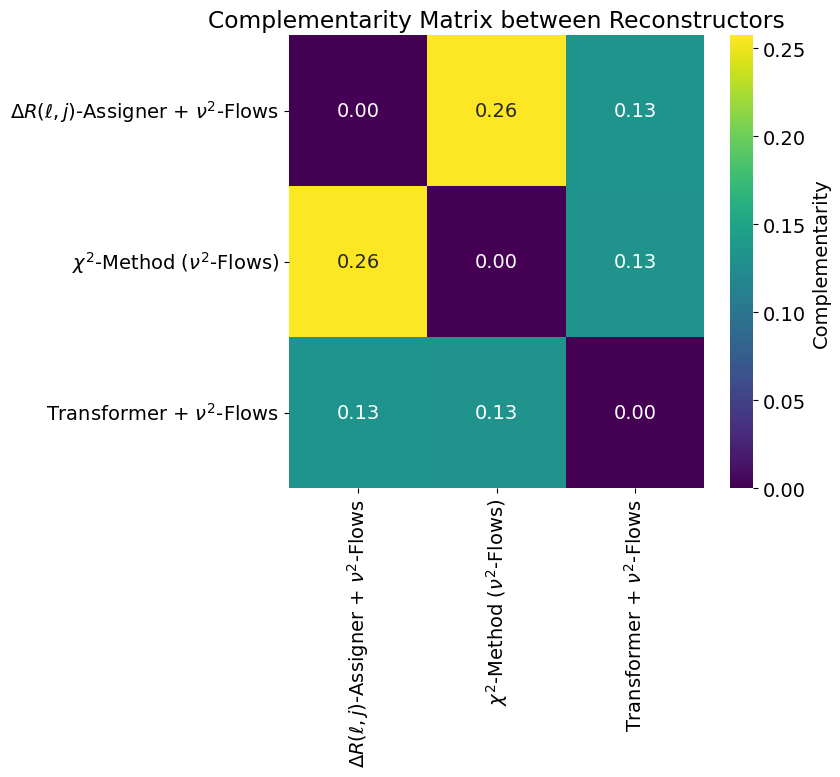

In [23]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(8.5, 8))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")